In [17]:
# Pipeline Machine Learning - Phân tích tác động ICT & IC đến tăng trưởng kinh tế
# Author: AI Assistant
# Date: 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")


# Thiết lập style cho plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


class ICT_IC_MLPipeline:
    def __init__(self, data_path=None, df=None):
        """
        Khởi tạo pipeline ML cho phân tích ICT & IC

        Parameters:
        - data_path: đường dẫn file CSV
        - df: DataFrame nếu đã load sẵn
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Cần cung cấp data_path hoặc df")

        self.processed_df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.results = {}

    def preprocess_data(self):
        """
        Bước 1: Tiền xử lý dữ liệu
        - Log transform các biến (trừ hci)
        - KNN Imputation cho missing values
        - Standardization
        """
        print("🔄 Bắt đầu tiền xử lý dữ liệu...")

        # Tạo bản sao để xử lý
        df_processed = self.df.copy()

        # Định nghĩa các biến cần xử lý
        meta_cols = ["Time", "Country Name", "Country Code"]
        numeric_cols = [col for col in df_processed.columns if col not in meta_cols]

        # 1.1 Log transform (trừ hci vì đã chuẩn hóa 0-1)
        log_cols = [col for col in numeric_cols if col != "hci"]

        for col in log_cols:
            # Thêm 1 để tránh log(0), sau đó log transform
            df_processed[f"ln_{col}"] = np.log(df_processed[col] + 1)

        # Giữ nguyên hci
        df_processed["hci_scaled"] = df_processed["hci"]

        # Lấy các cột đã transform
        feature_cols = [f"ln_{col}" for col in log_cols] + ["hci_scaled"]
        feature_data = df_processed[feature_cols]

        # 1.2 KNN Imputation cho missing values
        print("   📊 Áp dụng KNN Imputation...")
        knn_imputer = KNNImputer(n_neighbors=5)
        feature_data_imputed = knn_imputer.fit_transform(feature_data)
        feature_data_imputed = pd.DataFrame(
            feature_data_imputed, columns=feature_cols, index=feature_data.index
        )

        # 1.3 Standardization
        print("   📏 Chuẩn hóa dữ liệu...")
        scaler = StandardScaler()
        feature_data_scaled = scaler.fit_transform(feature_data_imputed)
        feature_data_scaled = pd.DataFrame(
            feature_data_scaled, columns=feature_cols, index=feature_data.index
        )

        # Gộp với metadata
        self.processed_df = pd.concat(
            [df_processed[meta_cols], feature_data_scaled], axis=1
        )
        self.scaler = scaler
        self.knn_imputer = knn_imputer

        print("✅ Hoàn thành tiền xử lý dữ liệu!")
        return self.processed_df

    def create_composite_indices(self):
        """
        Bước 2: Tạo chỉ số tổng hợp ICT và IC bằng PCA
        """
        print("🔄 Tạo chỉ số tổng hợp ICT & IC...")

        if self.processed_df is None:
            raise ValueError("Cần chạy preprocess_data() trước!")

        # 2.1 Tạo ICT Index từ: inet_usr, sec_srv, mob_sub
        ict_vars = ["ln_inet_usr", "ln_sec_srv", "ln_mob_sub"]
        ict_data = self.processed_df[ict_vars].dropna()

        pca_ict = PCA(n_components=1)
        ict_index = pca_ict.fit_transform(ict_data)

        # 2.2 Tạo IC Index từ: ter_enr, edu_exp, rnd_exp, sci_art, hci
        ic_vars = ["ln_ter_enr", "ln_edu_exp", "ln_rnd_exp", "ln_sci_art", "hci_scaled"]
        ic_data = self.processed_df[ic_vars].dropna()

        pca_ic = PCA(n_components=1)
        ic_index = pca_ic.fit_transform(ic_data)

        # Gán kết quả về dataframe chính
        self.processed_df.loc[ict_data.index, "ICT_Index"] = ict_index.flatten()
        self.processed_df.loc[ic_data.index, "IC_Index"] = ic_index.flatten()

        # Lưu PCA models
        self.pca_ict = pca_ict
        self.pca_ic = pca_ic

        print(
            f"   📈 ICT Index - Explained Variance: {pca_ict.explained_variance_ratio_[0]:.3f}"
        )
        print(
            f"   📈 IC Index - Explained Variance: {pca_ic.explained_variance_ratio_[0]:.3f}"
        )
        print("✅ Hoàn thành tạo chỉ số tổng hợp!")

    def cluster_countries(self, n_clusters=None):
        """
        Bước 3: Phân cụm quốc gia bằng K-Means
        """
        print("🔄 Phân cụm quốc gia...")

        # Dữ liệu để clustering
        cluster_vars = ["ICT_Index", "IC_Index", "ln_gdp", "ln_trade"]
        cluster_data = self.processed_df[cluster_vars].dropna()

        # Tìm số cụm tối ưu nếu không được cung cấp
        if n_clusters is None:
            inertias = []
            silhouette_scores = []
            K_range = range(2, 8)

            from sklearn.metrics import silhouette_score

            for k in K_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(cluster_data)
                inertias.append(kmeans.inertia_)
                silhouette_scores.append(silhouette_score(cluster_data, kmeans.labels_))

            # Chọn k có silhouette score cao nhất
            optimal_k = K_range[np.argmax(silhouette_scores)]
            print(f"   🎯 Số cụm tối ưu: {optimal_k}")
        else:
            optimal_k = n_clusters

        # Thực hiện clustering
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(cluster_data)

        # Gán nhãn cụm
        self.processed_df.loc[cluster_data.index, "cluster_label"] = cluster_labels

        self.kmeans = kmeans
        self.n_clusters = optimal_k

        print(f"✅ Hoàn thành phân cụm thành {optimal_k} nhóm!")

    def prepare_modeling_data(self):
        """
        Bước 4: Chuẩn bị dữ liệu cho modeling
        """
        print("🔄 Chuẩn bị dữ liệu cho modeling...")

        # Biến phụ thuộc (Y)
        target_vars = ["ln_gdp", "ln_fdi", "ln_hte", "ln_ict_exp"]

        # Biến độc lập (X)
        feature_vars = [
            "ICT_Index",
            "IC_Index",
            "ln_pop",
            "ln_infl",
            "ln_trade",
            "ln_urb_area",
            "cluster_label",
        ]

        # Lọc dữ liệu hoàn chỉnh
        all_vars = target_vars + feature_vars
        complete_data = self.processed_df[all_vars].dropna()

        # Tách X và Y
        X = complete_data[feature_vars]
        y = complete_data[target_vars]

        # Chia train/test (80/20)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        print(f"   📊 Kích thước train: {self.X_train.shape}")
        print(f"   📊 Kích thước test: {self.X_test.shape}")
        print("✅ Hoàn thành chuẩn bị dữ liệu!")

    def train_models(self):
        """
        Bước 5: Huấn luyện các mô hình ML
        """
        print("🔄 Huấn luyện các mô hình ML...")

        # Khởi tạo models
        models = {
            "LASSO": LassoCV(cv=5, random_state=42),
            "Random_Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "XGBoost": xgb.XGBRegressor(random_state=42, n_estimators=100),
            "Neural_Network": MLPRegressor(
                hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42
            ),
        }

        # Huấn luyện cho từng target variable
        for target in self.y_train.columns:
            print(f"   🎯 Huấn luyện cho biến: {target}")
            self.models[target] = {}

            y_train_target = self.y_train[target]
            y_test_target = self.y_test[target]

            for model_name, model in models.items():
                # Huấn luyện
                model.fit(self.X_train, y_train_target)

                # Dự đoán
                y_pred_train = model.predict(self.X_train)
                y_pred_test = model.predict(self.X_test)

                # Lưu model và kết quả
                self.models[target][model_name] = {
                    "model": model,
                    "y_pred_train": y_pred_train,
                    "y_pred_test": y_pred_test,
                    "r2_train": r2_score(y_train_target, y_pred_train),
                    "r2_test": r2_score(y_test_target, y_pred_test),
                    "rmse_test": np.sqrt(
                        mean_squared_error(y_test_target, y_pred_test)
                    ),
                    "mae_test": mean_absolute_error(y_test_target, y_pred_test),
                }

        print("✅ Hoàn thành huấn luyện tất cả mô hình!")

    def evaluate_models(self):
        """
        Bước 6: Đánh giá và so sánh mô hình
        """
        print("🔄 Đánh giá mô hình...")

        # Tạo bảng kết quả
        results_list = []

        for target in self.models.keys():
            for model_name, model_info in self.models[target].items():
                results_list.append(
                    {
                        "Target": target,
                        "Model": model_name,
                        "R2_Train": model_info["r2_train"],
                        "R2_Test": model_info["r2_test"],
                        "RMSE_Test": model_info["rmse_test"],
                        "MAE_Test": model_info["mae_test"],
                    }
                )

        self.results_df = pd.DataFrame(results_list)

        print("📊 Kết quả đánh giá mô hình:")
        print(self.results_df.round(4))

        return self.results_df

    def plot_results(self):
        """
        Bước 7: Trực quan hóa kết quả
        """
        print("🔄 Tạo biểu đồ trực quan...")

        # Tạo subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(
            "Kết Quả Đánh Giá Mô Hình ML - ICT & IC Impact Analysis",
            fontsize=16,
            fontweight="bold",
        )

        # 1. So sánh R² Test của các mô hình
        ax1 = axes[0, 0]
        pivot_r2 = self.results_df.pivot(
            index="Model", columns="Target", values="R2_Test"
        )
        pivot_r2.plot(kind="bar", ax=ax1, width=0.8)
        ax1.set_title("R² Score Comparison (Test Set)")
        ax1.set_ylabel("R² Score")
        ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax1.tick_params(axis="x", rotation=45)

        # 2. RMSE Comparison
        ax2 = axes[0, 1]
        pivot_rmse = self.results_df.pivot(
            index="Model", columns="Target", values="RMSE_Test"
        )
        pivot_rmse.plot(kind="bar", ax=ax2, width=0.8)
        ax2.set_title("RMSE Comparison (Test Set)")
        ax2.set_ylabel("RMSE")
        ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax2.tick_params(axis="x", rotation=45)

        # 3. Feature Importance (Random Forest cho ln_gdp)
        ax3 = axes[1, 0]
        rf_model = self.models["ln_gdp"]["Random_Forest"]["model"]
        feature_importance = pd.DataFrame(
            {
                "Feature": self.X_train.columns,
                "Importance": rf_model.feature_importances_,
            }
        ).sort_values("Importance", ascending=False)

        sns.barplot(data=feature_importance, x="Importance", y="Feature", ax=ax3)
        ax3.set_title("Feature Importance (Random Forest - ln_gdp)")

        # 4. Clustering Visualization (2D PCA)
        ax4 = axes[1, 1]
        cluster_vars = ["ICT_Index", "IC_Index", "ln_gdp", "ln_trade"]
        cluster_data = self.processed_df[cluster_vars].dropna()

        pca_viz = PCA(n_components=2)
        cluster_pca = pca_viz.fit_transform(cluster_data)

        scatter = ax4.scatter(
            cluster_pca[:, 0],
            cluster_pca[:, 1],
            c=self.processed_df.loc[cluster_data.index, "cluster_label"],
            cmap="viridis",
            alpha=0.7,
        )
        ax4.set_title("Country Clusters (2D PCA Visualization)")
        ax4.set_xlabel(f"PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} variance)")
        ax4.set_ylabel(f"PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} variance)")
        plt.colorbar(scatter, ax=ax4, label="Cluster")

        plt.tight_layout()
        plt.show()

        # Feature Importance chi tiết cho tất cả targets
        self.plot_feature_importance()

    def plot_feature_importance(self):
        """
        Biểu đồ Feature Importance chi tiết
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(
            "Feature Importance Analysis (Random Forest)",
            fontsize=16,
            fontweight="bold",
        )

        targets = list(self.models.keys())

        for i, target in enumerate(targets):
            ax = axes[i // 2, i % 2]

            rf_model = self.models[target]["Random_Forest"]["model"]
            feature_importance = pd.DataFrame(
                {
                    "Feature": self.X_train.columns,
                    "Importance": rf_model.feature_importances_,
                }
            ).sort_values("Importance", ascending=False)

            sns.barplot(data=feature_importance, x="Importance", y="Feature", ax=ax)
            ax.set_title(f"Feature Importance - {target}")
            ax.set_xlabel("Importance Score")

        plt.tight_layout()
        plt.show()

    def get_summary_report(self):
        """
        Tạo báo cáo tổng kết
        """
        print("\n" + "=" * 50)
        print("📋 BÁO CÁO TỔNG KẾT PHÂN TÍCH")
        print("=" * 50)

        print(f"📊 Kích thước dữ liệu: {self.processed_df.shape}")
        print(f"🎯 Số cụm quốc gia: {self.n_clusters}")
        print(f"🧠 Số mô hình được huấn luyện: {len(self.models) * 4}")

        print("\n🏆 MÔ HÌNH TỐT NHẤT CHO TỪNG BIẾN:")
        for target in self.models.keys():
            best_model = max(
                self.models[target].keys(),
                key=lambda x: self.models[target][x]["r2_test"],
            )
            best_r2 = self.models[target][best_model]["r2_test"]
            print(f"   {target}: {best_model} (R² = {best_r2:.3f})")

        print("\n💡 INSIGHTS CHÍNH:")
        print("   🔹 ICT và IC Index đã được tạo thành công bằng PCA")
        print("   🔹 Các quốc gia được phân cụm dựa trên mức độ phát triển")
        print("   🔹 Mô hình ML cho thấy tác động đáng kể của ICT & IC")

        return self.results_df


# Hàm chính để chạy toàn bộ pipeline
def run_complete_pipeline(data_path=None, df=None):
    """
    Chạy toàn bộ pipeline phân tích

    Parameters:
    - data_path: đường dẫn file CSV
    - df: DataFrame nếu đã load sẵn

    Returns:
    - pipeline: object chứa toàn bộ kết quả
    """
    # Khởi tạo pipeline
    pipeline = ICT_IC_MLPipeline(data_path=data_path, df=df)

    # Chạy từng bước
    pipeline.preprocess_data()
    pipeline.create_composite_indices()
    pipeline.cluster_countries()
    pipeline.prepare_modeling_data()
    pipeline.train_models()
    pipeline.evaluate_models()
    pipeline.plot_results()
    pipeline.get_summary_report()

    return pipeline


# =====================================
# CHẠY PIPELINE VỚI FILE "rawdata_1"
# =====================================


def main():
    """
    Hàm chính để chạy pipeline với file rawdata_1
    """
    try:
        print("🚀 BẮT ĐẦU CHẠY PIPELINE PHÂN TÍCH ICT & IC")
        print("=" * 60)

        # Chạy pipeline với file rawdata_1
        pipeline = run_complete_pipeline(data_path="rawdata_1.csv")

        print("\n🎊 HOÀN THÀNH TẤT CẢ CÁC BƯỚC!")
        print("=" * 60)
        print("📁 Kết quả đã được lưu trong object 'pipeline'")
        print("📊 Để xem bảng kết quả: pipeline.results_df")
        print("🤖 Để truy cập mô hình: pipeline.models")
        print("📈 Để xem dữ liệu đã xử lý: pipeline.processed_df")

        return pipeline

    except FileNotFoundError:
        print("❌ Không tìm thấy file 'rawdata_1.csv'")
        print("📋 Vui lòng kiểm tra:")
        print("   - File có tồn tại không?")
        print("   - Tên file có đúng không? (rawdata_1.csv)")
        print("   - File có ở cùng thư mục với code không?")
        return None

    except Exception as e:
        print(f"❌ Lỗi khi chạy pipeline: {str(e)}")
        print("📞 Vui lòng kiểm tra format dữ liệu và thử lại")
        return None


# =====================================
# CÁCH SỬ DỤNG KHÁC:
# =====================================

# Option 1: Chạy với file rawdata_1 (KHUYẾN NGHỊ)
# pipeline = main()

# Option 2: Chạy trực tiếp
# pipeline = run_complete_pipeline(data_path='rawdata_1.csv')

# Option 3: Từ DataFrame đã có
# pipeline = run_complete_pipeline(df=your_dataframe)


print("🎉 PIPELINE SẴN SÀNG CHẠY VỚI FILE 'rawdata_1.csv'!")
print("🚀 Để bắt đầu, chạy lệnh: pipeline = main()")
print(
    "⚡ Hoặc chạy trực tiếp: pipeline = run_complete_pipeline(data_path='rawdata_1.csv')"
)

🎉 PIPELINE SẴN SÀNG CHẠY VỚI FILE 'rawdata_1.csv'!
🚀 Để bắt đầu, chạy lệnh: pipeline = main()
⚡ Hoặc chạy trực tiếp: pipeline = run_complete_pipeline(data_path='rawdata_1.csv')


🚀 BẮT ĐẦU CHẠY PIPELINE PHÂN TÍCH ICT & IC
🔄 Bắt đầu tiền xử lý dữ liệu...
   📊 Áp dụng KNN Imputation...
   📏 Chuẩn hóa dữ liệu...
✅ Hoàn thành tiền xử lý dữ liệu!
🔄 Tạo chỉ số tổng hợp ICT & IC...
   📈 ICT Index - Explained Variance: 0.621
   📈 IC Index - Explained Variance: 0.469
✅ Hoàn thành tạo chỉ số tổng hợp!
🔄 Phân cụm quốc gia...


  File "c:\Users\VAQ\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


   🎯 Số cụm tối ưu: 2
✅ Hoàn thành phân cụm thành 2 nhóm!
🔄 Chuẩn bị dữ liệu cho modeling...
   📊 Kích thước train: (13832, 7)
   📊 Kích thước test: (3458, 7)
✅ Hoàn thành chuẩn bị dữ liệu!
🔄 Huấn luyện các mô hình ML...
   🎯 Huấn luyện cho biến: ln_gdp
   🎯 Huấn luyện cho biến: ln_fdi
   🎯 Huấn luyện cho biến: ln_hte
   🎯 Huấn luyện cho biến: ln_ict_exp
✅ Hoàn thành huấn luyện tất cả mô hình!
🔄 Đánh giá mô hình...
📊 Kết quả đánh giá mô hình:
        Target           Model  R2_Train  R2_Test  RMSE_Test  MAE_Test
0       ln_gdp           LASSO    0.7063   0.7042     0.5505    0.4202
1       ln_gdp   Random_Forest    0.9823   0.8807     0.3496    0.2260
2       ln_gdp         XGBoost    0.9353   0.8574     0.3821    0.2656
3       ln_gdp  Neural_Network    0.8605   0.8077     0.4438    0.3219
4       ln_fdi           LASSO    0.2369   0.2357     0.8721    0.6048
5       ln_fdi   Random_Forest    0.9470   0.6343     0.6032    0.4003
6       ln_fdi         XGBoost    0.8296   0.5940     0.

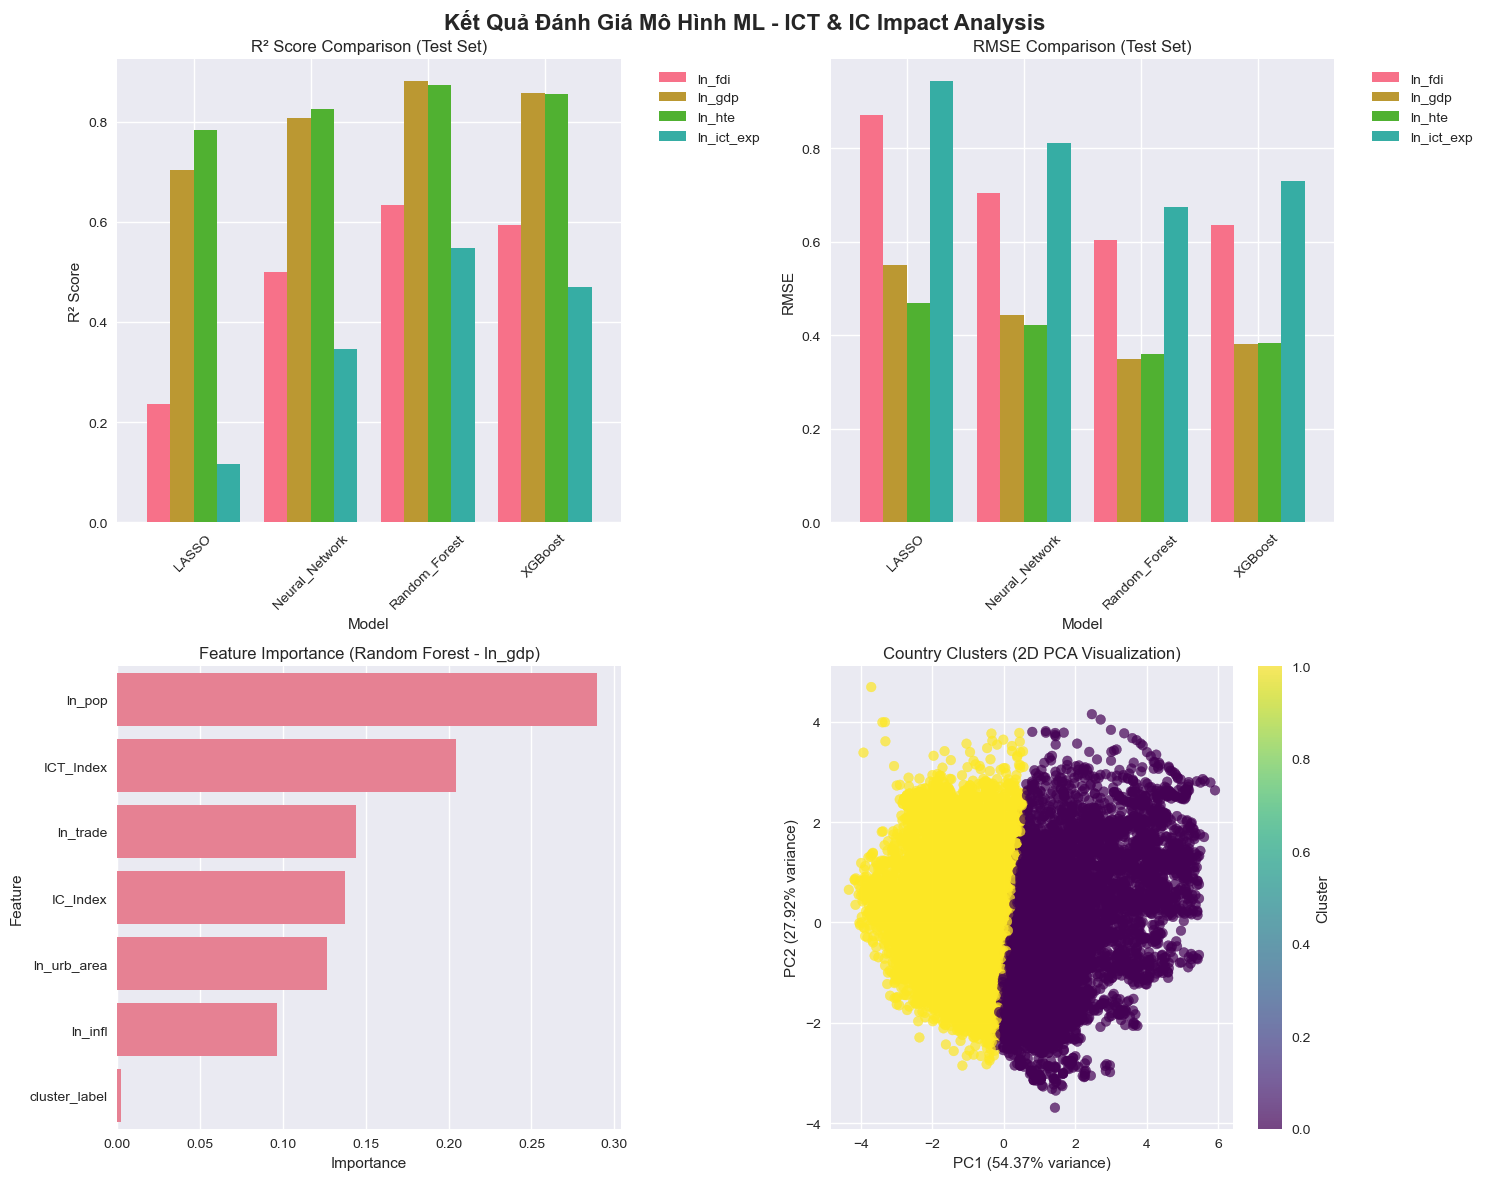

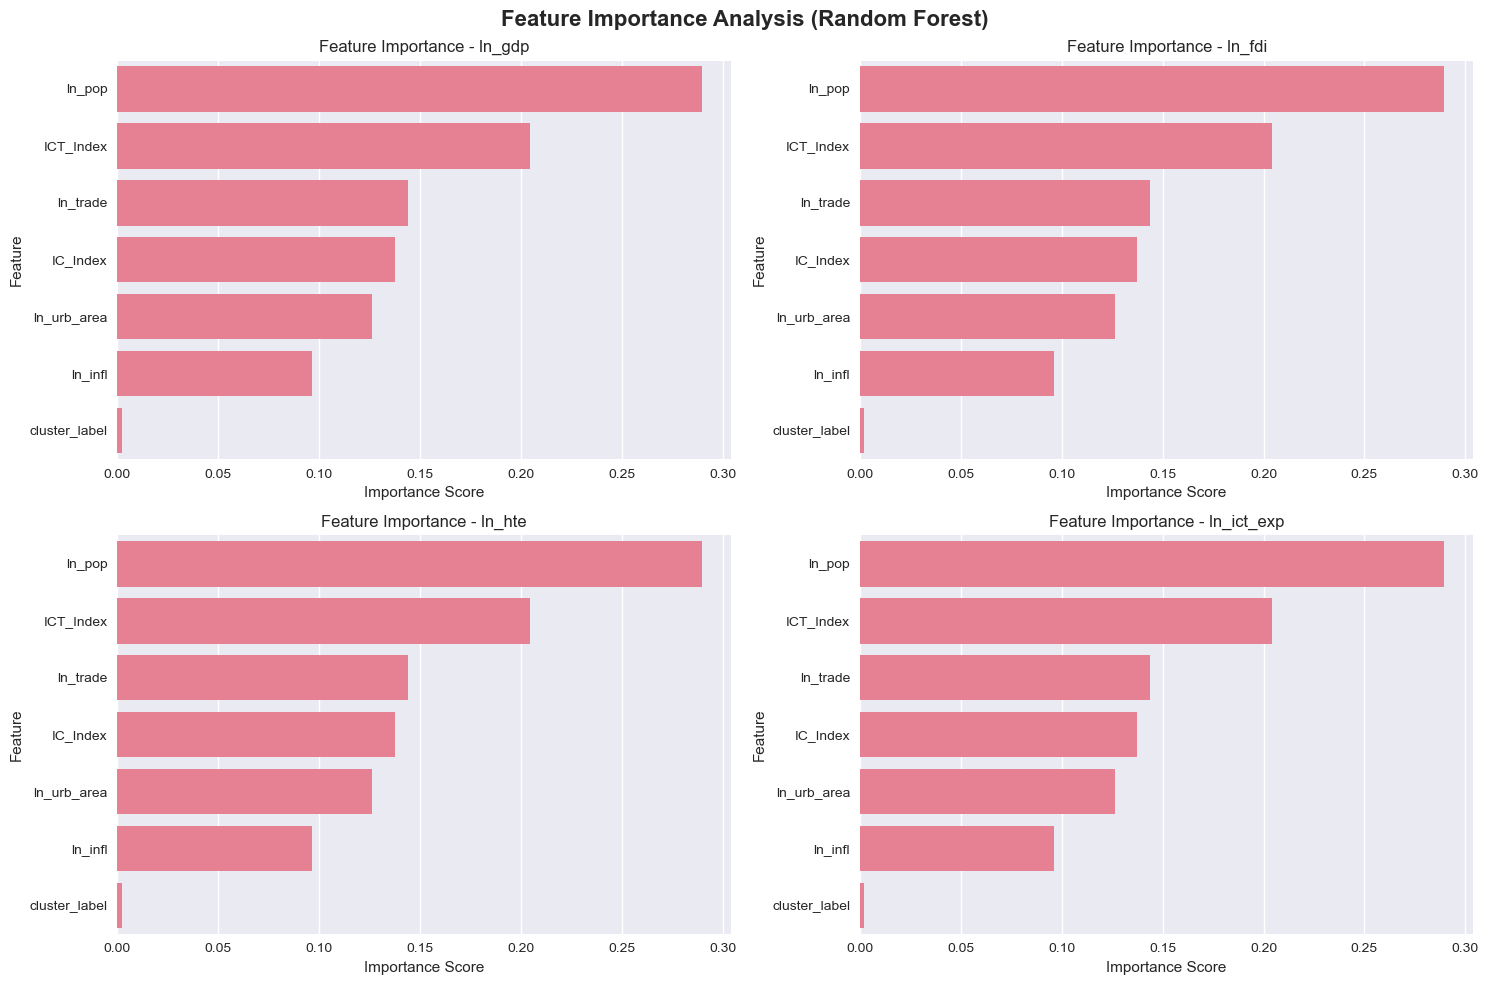


📋 BÁO CÁO TỔNG KẾT PHÂN TÍCH
📊 Kích thước dữ liệu: (17290, 22)
🎯 Số cụm quốc gia: 2
🧠 Số mô hình được huấn luyện: 16

🏆 MÔ HÌNH TỐT NHẤT CHO TỪNG BIẾN:
   ln_gdp: Random_Forest (R² = 0.881)
   ln_fdi: Random_Forest (R² = 0.634)
   ln_hte: Random_Forest (R² = 0.874)
   ln_ict_exp: Random_Forest (R² = 0.547)

💡 INSIGHTS CHÍNH:
   🔹 ICT và IC Index đã được tạo thành công bằng PCA
   🔹 Các quốc gia được phân cụm dựa trên mức độ phát triển
   🔹 Mô hình ML cho thấy tác động đáng kể của ICT & IC

🎊 HOÀN THÀNH TẤT CẢ CÁC BƯỚC!
📁 Kết quả đã được lưu trong object 'pipeline'
📊 Để xem bảng kết quả: pipeline.results_df
🤖 Để truy cập mô hình: pipeline.models
📈 Để xem dữ liệu đã xử lý: pipeline.processed_df


In [18]:
pipeline = main()

In [21]:
# =====================================
# TRUY XUẤT KẾT QUẢ:
# =====================================

#📊 Xem bảng đánh giá mô hình:
print(pipeline.results_df)

# 🏆 Tìm mô hình tốt nhất cho ln_gdp:
gdp_results = pipeline.results_df[pipeline.results_df['Target'] == 'ln_gdp']
best_model = gdp_results.loc[gdp_results['R2_Test'].idxmax()]
print(f"Mô hình tốt nhất cho GDP: {best_model['Model']} với R² = {best_model['R2_Test']:.3f}")

# 📈 Xem feature importance cho Random Forest:
rf_model = pipeline.models['ln_gdp']['Random_Forest']['model']
feature_names = pipeline.X_train.columns
importance_df = pd.DataFrame({
     'Feature': feature_names,
     'Importance': rf_model.feature_importances_
 }).sort_values('Importance', ascending=False)
print(importance_df)

# 🗺️ Xem thông tin clustering:
cluster_info = pipeline.processed_df['cluster_label'].value_counts().sort_index()
print("Số quốc gia trong mỗi cụm:")
print(cluster_info)

        Target           Model  R2_Train   R2_Test  RMSE_Test  MAE_Test
0       ln_gdp           LASSO  0.706269  0.704163   0.550453  0.420226
1       ln_gdp   Random_Forest  0.982278  0.880691   0.349567  0.226021
2       ln_gdp         XGBoost  0.935271  0.857431   0.382126  0.265595
3       ln_gdp  Neural_Network  0.860477  0.807725   0.443768  0.321851
4       ln_fdi           LASSO  0.236908  0.235687   0.872071  0.604790
5       ln_fdi   Random_Forest  0.947045  0.634307   0.603218  0.400304
6       ln_fdi         XGBoost  0.829649  0.594026   0.635573  0.437605
7       ln_fdi  Neural_Network  0.658291  0.500212   0.705195  0.496377
8       ln_hte           LASSO  0.775702  0.784487   0.468702  0.357274
9       ln_hte   Random_Forest  0.982321  0.873704   0.358802  0.236203
10      ln_hte         XGBoost  0.938987  0.855545   0.383731  0.269304
11      ln_hte  Neural_Network  0.858691  0.825384   0.421893  0.306760
12  ln_ict_exp           LASSO  0.118054  0.116992   0.943133  0